In [2]:
#とりあえず、九州電力の7月の表をよみこんで図を書いて分析したいな
# -*- coding: utf-8 -*-
import pandas as pd

file = "eria_jukyu_202507_09.csv"
df = pd.read_csv(file, encoding="cp932")  # もしくは encoding="shift_jis"
print(df.head())
print(df.info())




   単位[MW平均] Unnamed: 1 Unnamed: 2   供給力 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0      DATE       TIME      エリア需要   原子力    火力（ＬＮＧ）     火力（石炭）     火力（石油）   
1  20250701       0:30       9806  4110        574       4092        108   
2  20250701       1:00       9382  4110        442       3964        102   
3  20250701       1:30       9136  4110        444       3822        102   
4  20250701       2:00       8970  4110        438       3790         96   

  Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 10 Unnamed: 11 Unnamed: 12  \
0    火力（その他）         水力         地熱       バイオマス     太陽光発電実績    太陽光出力制御量   
1        462        534        146         824           0           0   
2        444        516        144         826           0           0   
3        442        502        146         826           0           0   
4        444        496        144         828           0           0   

  Unnamed: 13 Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17 Unnamed: 18  \
0      風力発電実績     風力出

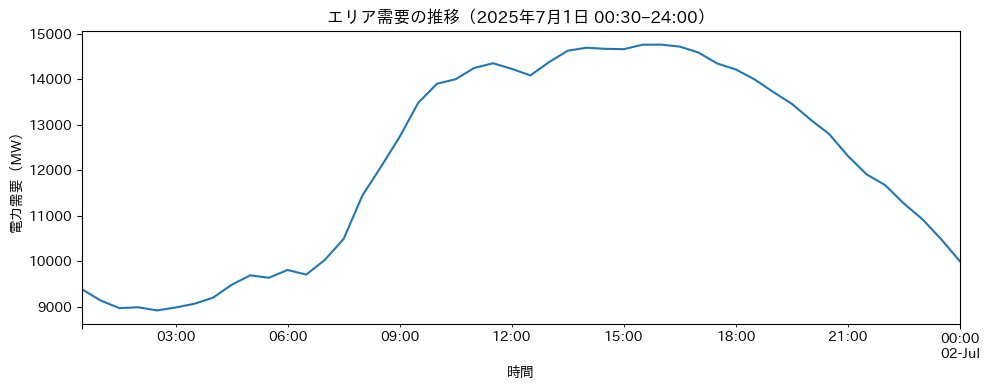

In [6]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

file = "eria_jukyu_202507_09.csv"

# Excel由来CSV想定でCP932。UTF-8なら encoding を省略/変更してください
df = pd.read_csv(file, encoding="cp932")

# 3列目の3～50行目（0始まりの iloc で 2:50, 2）
s = df.iloc[2:50, 2]

# 数値化（カンマ等が混じってもOKにする）
y = pd.to_numeric(s, errors="coerce")

# 00:30 から 30分刻みで 48 ステップ → 最後は 24:00
idx = pd.date_range(start="2025-07-01 00:30", periods=len(y), freq="30min")

# 時系列にしてプロット
ser = pd.Series(y.values, index=idx, name="エリア需要")
plt.figure(figsize=(10, 4))
ser.plot()
plt.title("エリア需要の推移（2025年7月1日 00:30–24:00）")
plt.xlabel("時間")
plt.ylabel("電力需要（MW）")
plt.tight_layout()
plt.show()


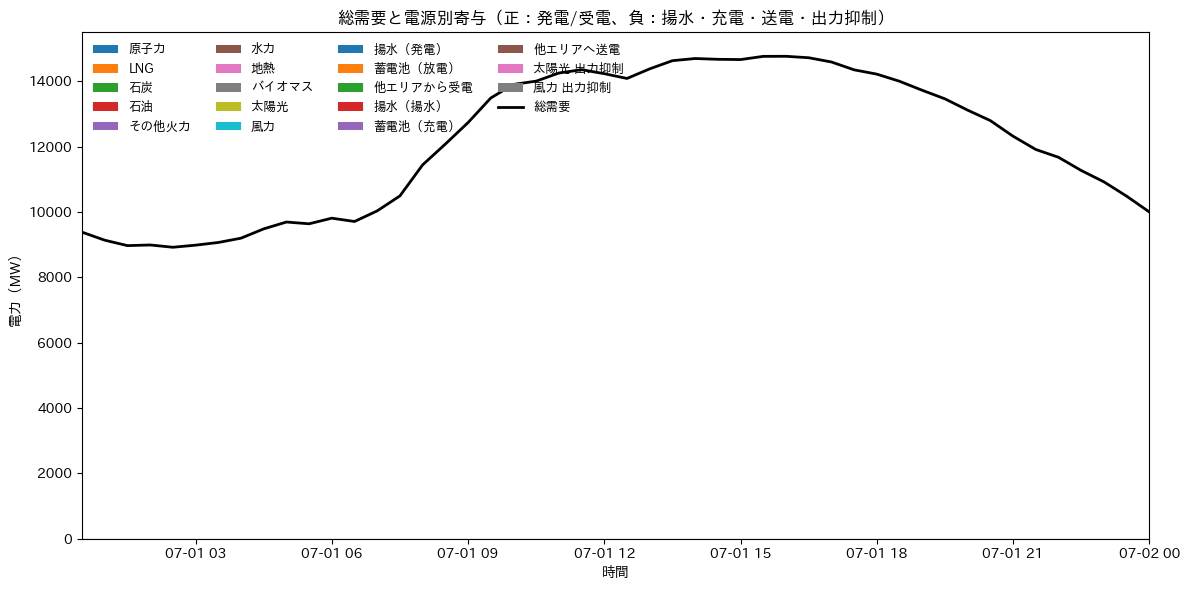

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

file = "eria_jukyu_202507_09.csv"
df = pd.read_csv(file, encoding="cp932")

# 便利関数：数値化（カンマ等を除去）
def to_num(s):
    return pd.to_numeric(
        s.astype(str).str.replace(',', '').str.replace('\u3000','').str.strip(),
        errors='coerce'
    ).fillna(0)

sl = slice(2, 50)  # 3～50行目（48点）

# ご指定の列番号に合わせて取り出し
demand          = to_num(df.iloc[sl,  2])   # 総需要
nuclear         = to_num(df.iloc[sl,  3])   # 原子力
lng_            = to_num(df.iloc[sl,  4])   # 火力(LNG)
coal            = to_num(df.iloc[sl,  5])   # 火力(石炭)
oil             = to_num(df.iloc[sl,  6])   # 火力(石油)
other_fire      = to_num(df.iloc[sl,  7])   # 火力(その他)
hydro           = to_num(df.iloc[sl,  8])   # 水力
geothermal      = to_num(df.iloc[sl,  9])   # 地熱
biomass         = to_num(df.iloc[sl, 10])   # バイオマス
solar           = to_num(df.iloc[sl, 11])   # 太陽光
reduced_solar   = to_num(df.iloc[sl, 12])   # 太陽光出力抑制（正→マイナスで描画）
wind            = to_num(df.iloc[sl, 13])   # 風力
reduced_wind    = to_num(df.iloc[sl, 14])   # 風力出力抑制（正→マイナスで描画）
pumped          = to_num(df.iloc[sl, 15])   # 揚水（発電＋／揚水−想定）
battery         = to_num(df.iloc[sl, 16])   # 蓄電池（放電＋／充電−想定）
tie             = to_num(df.iloc[sl, 17])   # 他エリアへの電力供給（送電＋／受電−想定）

# 時間軸：00:30 から 30分刻みで 48 ステップ（最後は 24:00）
idx = pd.date_range(start="2025-07-01 00:30", periods=len(demand), freq="30min")

# 0より上に積む系列（正の寄与）
pos = pd.DataFrame({
    "原子力": nuclear,
    "LNG": lng_,
    "石炭": coal,
    "石油": oil,
    "その他火力": other_fire,
    "水力": hydro,
    "地熱": geothermal,
    "バイオマス": biomass,
    "太陽光": solar,
    "風力": wind,
    "揚水（発電）": pumped.clip(lower=0),
    "蓄電池（放電）": battery.clip(lower=0),
    "他エリアから受電": (-tie).clip(lower=0),  # tieが負=受電を正に
}, index=idx).fillna(0)

# 0より下に積む系列（負の寄与）
neg = pd.DataFrame({
    "揚水（揚水）": pumped.clip(upper=0),              # そのまま負
    "蓄電池（充電）": battery.clip(upper=0),             # そのまま負
    "他エリアへ送電": -tie.clip(lower=0),               # 送電（正）を負に
    "太陽光 出力抑制": -reduced_solar,                 # 抑制量を負に
    "風力 出力抑制": -reduced_wind,                    # 同上
}, index=idx).fillna(0)

# 描画
fig, ax = plt.subplots(figsize=(12, 6))
# 正のスタック
ax.stackplot(idx, pos.T.values, labels=pos.columns)
# 負のスタック（値は負のままでOK。下方向に積まれます）
ax.stackplot(idx, neg.T.values, labels=neg.columns)
# 総需要
ax.plot(idx, demand.values, color="k", lw=2, label="総需要")

ax.axhline(0, color="k", lw=0.8)  # 0ライン
ax.set_title("総需要と電源別寄与（正：発電/受電、負：揚水・充電・送電・出力抑制）")
ax.set_xlabel("時間")
ax.set_ylabel("電力（MW）")
ax.margins(x=0)
ax.legend(loc="upper left", ncol=4, fontsize=9, frameon=False)
plt.tight_layout()
plt.show()


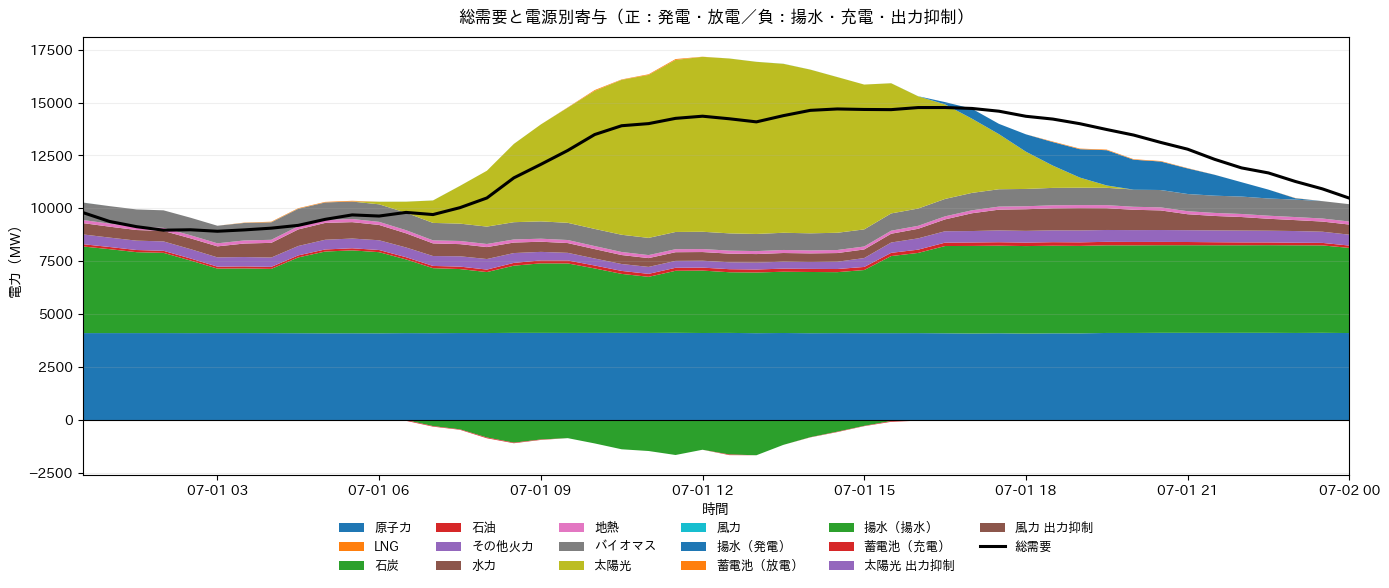

In [11]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

file = "eria_jukyu_202507_09.csv"

# 1) 1行目が単位、2行目がヘッダ → header=1
df0 = pd.read_csv(file, encoding="cp932", header=1)

# 2) 列名の整形（全角空白や全角カッコを除去/統一）
df0.columns = (df0.columns
               .str.replace('\u3000', '', regex=False)  # 全角空白
               .str.replace(' ', '', regex=False)       # 半角空白
               .str.replace('（', '(', regex=False)
               .str.replace('）', ')', regex=False)
               .str.strip())

# 3) DATE + TIME → datetime へ（TIME が "H:MM" でも確実に通す）
#    例: "0:30" → h=0, m=30 として timedelta を作る
_time = df0['TIME'].astype(str).str.replace('：', ':', regex=False)
hm = _time.str.extract(r'(?P<h>\d+):(?P<m>\d+)', expand=True).fillna('0').astype(int)
delta = pd.to_timedelta(hm['h'], unit='h') + pd.to_timedelta(hm['m'], unit='m')
date = pd.to_datetime(df0['DATE'].astype(str), format='%Y%m%d', errors='coerce')
df0.insert(0, 'datetime', date + delta)

# 4) その日の最初の 48 ステップ（00:30→24:00）を採用
first_day = int(df0.loc[0, 'DATE'])
df = df0[df0['DATE'] == first_day].iloc[:48].copy()
df = df.set_index('datetime')  # 以降、時系列インデックスで扱う

# 5) 数値化ヘルパー（カンマや空白が混ざってもOK）
def to_num(s):
    return pd.to_numeric(
        s.astype(str).str.replace(',', '', regex=False).str.replace('\u3000','', regex=False).str.strip(),
        errors='coerce'
    ).fillna(0.0)

# 6) 部分一致で列を安全に探すヘルパー
def find_col(*keys):
    for c in df.columns:
        name = str(c)
        if all(k in name for k in keys):
            return c
    return None

def series(*keys):
    c = find_col(*keys)
    return to_num(df[c]) if c else pd.Series(0.0, index=df.index)

# 7) 系列の取り出し（スクショの列名に合わせてキーを指定）
demand     = series('エリア需要')
nuclear    = series('原子力')
lng_       = series('LNG') if find_col('LNG') else series('火力', 'LNG')
coal       = series('石炭') if find_col('石炭') else series('火力', '石炭')
oil        = series('石油') if find_col('石油') else series('火力', '石油')
other_fire = series('その他')  # 「火力(その他)」想定。なければ自動で0
hydro      = series('水力')
geo        = series('地熱')
biomass    = series('バイオマス')
solar      = series('太陽光発電')
solar_cut  = series('太陽光出力抑制')
wind       = series('風力発電')
wind_cut   = series('風力出力抑制')
pumped     = series('揚水')      # 発電＋／揚水(汲上げ)− の想定
battery    = series('蓄電池')    # 放電＋／充電− の想定
# もし「他エリアからの受電/送電」列が別にあれば、同様に series('受電') / series('送電') で追加

# 8) 正側（発電・放電・受電）と負側（揚水・充電・出力抑制・送電）に分ける
pos = pd.DataFrame({
    '原子力': nuclear,
    'LNG': lng_,
    '石炭': coal,
    '石油': oil,
    'その他火力': other_fire,
    '水力': hydro,
    '地熱': geo,
    'バイオマス': biomass,
    '太陽光': solar,
    '風力': wind,
    '揚水（発電）': pumped.clip(lower=0),      # 発電分だけ上側へ
    '蓄電池（放電）': battery.clip(lower=0),   # 放電分だけ上側へ
}, index=df.index).fillna(0.0)

neg = pd.DataFrame({
    '揚水（揚水）': pumped.clip(upper=0),      # 汲上げ（負）
    '蓄電池（充電）': battery.clip(upper=0),     # 充電（負）
    '太陽光 出力抑制': -solar_cut,             # 抑制を負へ
    '風力 出力抑制': -wind_cut,                # 同上
}, index=df.index).fillna(0.0)

# 9) 描画（stackplot は * で列ごとに渡す）
fig, ax = plt.subplots(figsize=(14, 6))

# 上側：正の寄与（発電・放電）
if pos.values.any():
    ax.stackplot(df.index, *pos.T.values, labels=pos.columns)

# 下側：負の寄与（揚水・充電・出力抑制 等）
if neg.values.any():
    ax.stackplot(df.index, *neg.T.values, labels=neg.columns)

# 総需要ライン（黒）
ax.plot(df.index, demand.values, color='k', lw=2.2, label='総需要', zorder=5)

ax.axhline(0, color='k', lw=0.8)
ax.set_title('総需要と電源別寄与（正：発電・放電／負：揚水・充電・出力抑制）', pad=10)
ax.set_xlabel('時間')
ax.set_ylabel('電力（MW）')
ax.margins(x=0)
ax.grid(axis='y', alpha=0.2)

# 凡例を2段に
ax.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.08), frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

# ---（任意のチェック）---
# print('正側合計(MWh 相当/30分平均×件数):', pos.sum().sum())
# print('負側合計(MWh 相当):', neg.sum().sum())
# print('描画対象点数:', len(df.index))  # 48 を想定


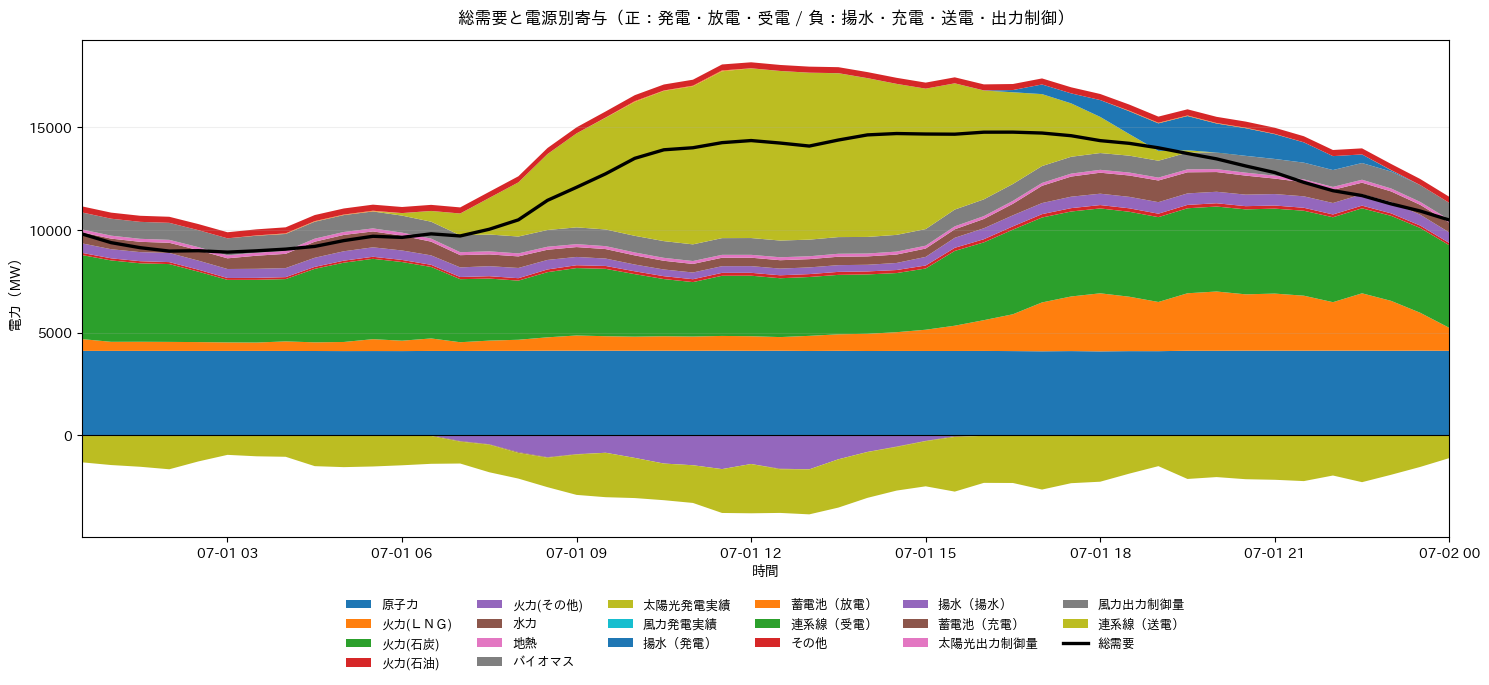

In [12]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

file = "eria_jukyu_202507_09.csv"

# 1) 1行目が単位、2行目がヘッダ
df0 = pd.read_csv(file, encoding="cp932", header=1)

# 2) 列名整形（空白類だけ除去。全角カッコや全角英字はそのまま）
df0.columns = (df0.columns
               .str.replace(' ', '', regex=False)
               .str.replace('\u3000', '', regex=False)
               .str.strip())

# 3) DATE + TIME → datetime（"H:MM" と "24:00" に対応）
t = df0["TIME"].astype(str).str.replace('：', ':', regex=False)
hm = t.str.extract(r'(?P<h>\d+):(?P<m>\d+)', expand=True).fillna('0').astype(int)
date = pd.to_datetime(df0["DATE"].astype(str), format="%Y%m%d", errors="coerce")
# 24:00 → 翌日00:00 へ
dt = date + pd.to_timedelta(hm["h"] % 24, unit="h") \
          + pd.to_timedelta(hm["m"], unit="m") \
          + pd.to_timedelta(hm["h"] // 24, unit="D")
df0.insert(0, "datetime", dt)

# 4) 先頭日の 48 ステップ（00:30→24:00）を使用
first_day = int(df0.loc[0, "DATE"])
df = df0[df0["DATE"] == first_day].iloc[:48].copy().set_index("datetime")

# 5) 数値化（カンマ/空白の混入に耐性）
def to_num(s):
    return pd.to_numeric(s.astype(str)
                           .str.replace(',', '', regex=False)
                           .str.replace('\u3000', '', regex=False)
                           .str.strip(), errors="coerce").fillna(0.0)

# 6) 各列（**すべて**取り出します）
demand   = to_num(df["エリア需要"])
nuclear  = to_num(df["原子力"])
lng_     = to_num(df["火力（ＬＮＧ）"])
coal     = to_num(df["火力（石炭）"])
oil      = to_num(df["火力（石油）"])
other_tf = to_num(df["火力（その他）"])
hydro    = to_num(df["水力"])
geo      = to_num(df["地熱"])
biomass  = to_num(df["バイオマス"])
solar    = to_num(df["太陽光発電実績"])
solar_cut= to_num(df["太陽光出力制御量"])
wind     = to_num(df["風力発電実績"])
wind_cut = to_num(df["風力出力制御量"])
pumped   = to_num(df["揚水"])        # 発電＋／揚水(くみ上げ)− の想定
battery  = to_num(df["蓄電池"])      # 放電＋／充電− の想定
tie      = to_num(df["連系線"])      # 正=送電/負=受電（一般的な符号を想定）
other    = to_num(df["その他"])      # その他（発電等）

# 7) 正（上側）と負（下側）に分ける
#    連系線は 受電(負値)→上側・送電(正値)→下側 に振り分け
pos = pd.DataFrame({
    "原子力": nuclear,
    "火力(ＬＮＧ)": lng_,
    "火力(石炭)": coal,
    "火力(石油)": oil,
    "火力(その他)": other_tf,
    "水力": hydro,
    "地熱": geo,
    "バイオマス": biomass,
    "太陽光発電実績": solar,
    "風力発電実績": wind,
    "揚水（発電）": pumped.clip(lower=0),
    "蓄電池（放電）": battery.clip(lower=0),
    "連系線（受電）": (-tie).clip(lower=0),
    "その他": other,
}, index=df.index).fillna(0.0)

neg = pd.DataFrame({
    "揚水（揚水）": pumped.clip(upper=0),
    "蓄電池（充電）": battery.clip(upper=0),
    "太陽光出力制御量": -solar_cut,   # 使えなかった分を負へ
    "風力出力制御量": -wind_cut,       # 同上
    "連系線（送電）": -tie.clip(lower=0),
}, index=df.index).fillna(0.0)

# 8) 描画
fig, ax = plt.subplots(figsize=(15, 7))

# 上側（発電・放電・受電）
if pos.values.any():
    ax.stackplot(df.index, *pos.T.values, labels=pos.columns)

# 下側（揚水・充電・送電・出力制御）
if neg.values.any():
    ax.stackplot(df.index, *neg.T.values, labels=neg.columns)

# 総需要（黒線）
ax.plot(df.index, demand.values, color="k", lw=2.4, label="総需要", zorder=5)

ax.axhline(0, color="k", lw=0.8)
ax.set_title("総需要と電源別寄与（正：発電・放電・受電 / 負：揚水・充電・送電・出力制御）", pad=12)
ax.set_xlabel("時間"); ax.set_ylabel("電力（MW）")
ax.margins(x=0); ax.grid(axis="y", alpha=0.2)

# 凡例：2段で重なり回避（全要素表示）
ax.legend(loc="upper center", ncol=6, bbox_to_anchor=(0.5, -0.10),
          frameon=False, fontsize=9)
plt.tight_layout()
plt.show()
